# Spotify - Classification


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
# Loading data
df1 = pd.read_csv('data/CS98XClassificationTest.csv')
df2 = pd.read_csv('data/CS98XClassificationTrain.csv')

test_df = df1.copy()
train_df = df2.copy()

In [32]:
# Dropping null values from training set as there is no value to using these instances to train the model
train_df = train_df.loc[train_df['top genre'].notna(), :]

In [33]:
train_df.head()

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards
2,3,How Deep Is Your Love,Bee Gees,1979,105,36,63,-9,13,67,245,11,3,77,adult standards
3,4,Woman in Love,Barbra Streisand,1980,170,28,47,-16,13,33,232,25,3,67,adult standards
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,1973,121,47,56,-8,15,40,193,45,3,63,glam rock
5,6,Grenade,Bruno Mars,2010,110,56,71,-7,12,23,223,15,6,74,pop


# Exploratory Data Analysis

## Genre Analysis

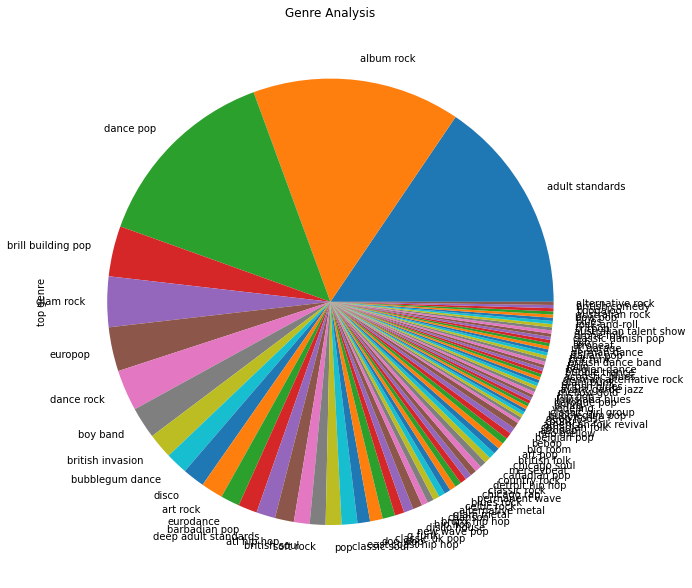

In [45]:
plt.figure(figsize = (10,15))

train_df['top genre'].value_counts().plot.pie()
plt.title("Genre Analysis")
plt.show()
plt.close()

From the pie chart it is clear that there is many subgenres 

## Co-relation between variables

Before analysing all the variables independently, in order to get an idea how the variables are corelated to each other, a heat map was generated using 'sns.heatmap()'. Most of the variables in the dataset are positively corelated to each other which means they implepent similar behavior. 

Text(0.5, 1.0, 'Co-relation Matrix')

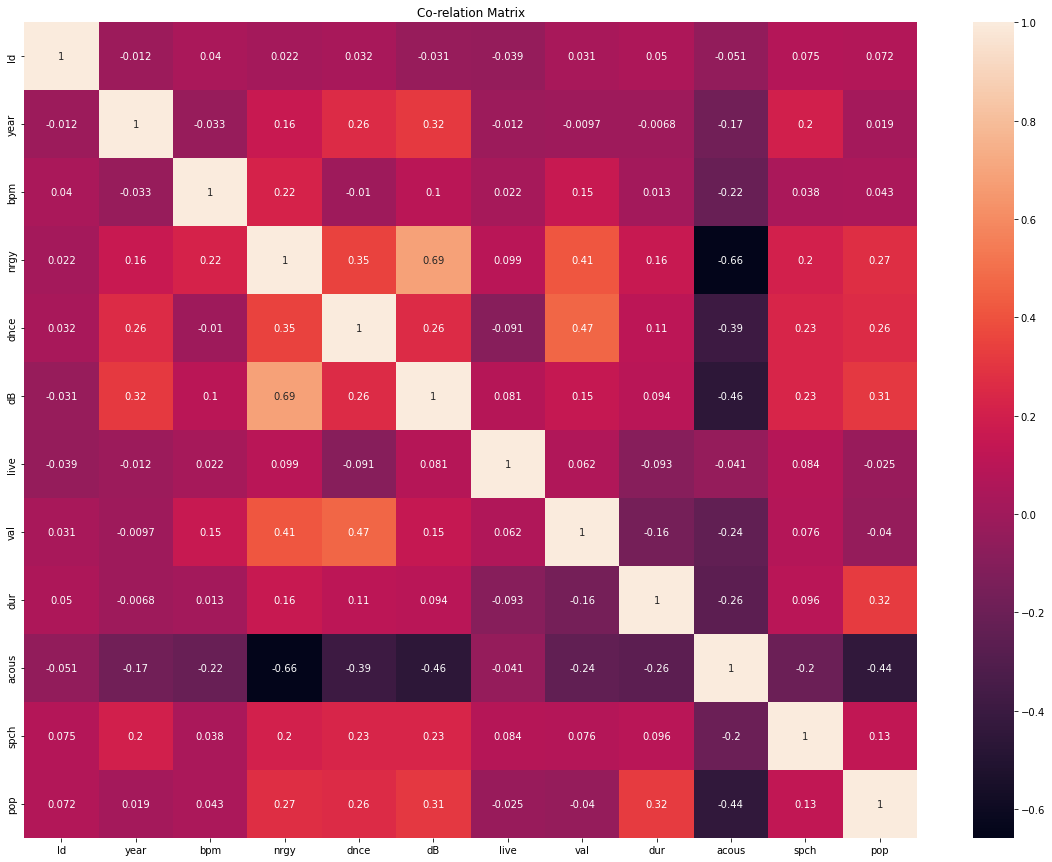

In [36]:
plt.figure(figsize = (20,15))
sns.heatmap(train_df.corr(),annot = True)
plt.title('Co-relation Matrix')

The energy (nrgy) feature has collinearity with other features so we will investigate the effect of removing it from the model. However the highest value for collinearity is only 0.69, which is for loadness (dB) and energy (nrgy). This means that the collinearity may not overly effect the model. 

### Analysis Relationship between features

Text(0, 0.5, 'Loudness')

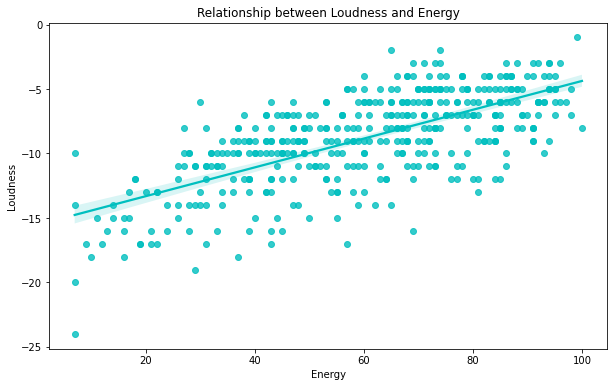

In [47]:
plt.figure(figsize = (10,6))
sns.regplot(data = train_df, y ='dB', x='nrgy', color= "c")
plt.title("Relationship between Loudness and Energy")
plt.xlabel('Energy')
plt.ylabel('Loudness')

Text(0, 0.5, 'Acoustics')

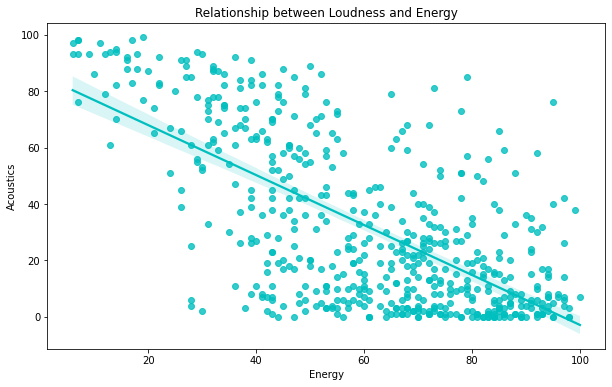

In [51]:
plt.figure(figsize = (10,6))
sns.regplot(data = df, y ='acous', x='nrgy', color= "c")
plt.title("Relationship between Loudness and Energy")
plt.xlabel('Energy')
plt.ylabel('Acoustics')

## Coverting categorical features to continuous features

To use the categorical features in the classifier we need to convert the categorical data into numerical features. This could have been done by directly converting the features into numerical labels. This method however can lead to finding relationships that don't really exist. Instead we use One Hot Encoding to convert to numerical features.

The problem with using the One Hot Encoder on a dataset that already has high dimensionality can result in significantly worse dimensionality. This can make algorithms inefficient. To help manage this we use PCA (a method of applying singular value decomposition) to reduce the dimensionality of our data set.

In [6]:
# Seperate out the targets for the training set
y = train_df['top genre']
train_df = train_df.drop('top genre', axis=1)

# Combining the training and testing set so that the feature are the same when processing steps are applied
df = train_df.append(test_df,ignore_index=True)

In [7]:
# Removing the nrgy feature due to high collinearity found in data exploration.
nocol_df = df.drop(['nrgy'], axis=1)

To keep the code tidy and modular, we build a function that applies both OHE and PCA to properly prepare the dataset for training. It is worth noting that the data is scaled using the StandardScalar() function, so this will not need to be reapplied when training the data.

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
def genre_processing(df):
    x = df.drop(['Id', 'title'], axis=1)

    # Factorising the catigorcal variable
    artist = x['artist']
    artist_encoded, artist_categories = artist.factorize()
    enc = OneHotEncoder()
    
    # Need to reshape into 2-d array
    artist_1hot = enc.fit_transform(artist_encoded.reshape(-1,1))
    artist_1hot = artist_1hot.toarray()
    
    train_num = x.drop('artist', axis=1)
    cat_attribs = ['artist']
    num_attribs = list(train_num)
    
    std_scaler = preprocessing.StandardScaler()
    train_num[num_attribs] = std_scaler.fit_transform(train_num[num_attribs])
    
    enc_data = pd.DataFrame(artist_1hot)
    enc_data.columns = artist_categories
    enc_data.index = artist.index
    # Combine the one hot encoded artist features with the rest of the data set
    train_prepared = train_num.join(enc_data)
    
    # One hot encoding the artist feature has made the data set very sparse
    # Therefore need to use PCA to reduce the dimensionality of the data
    pca = PCA(n_components=0.95)
    train_reduced = pca.fit_transform(train_prepared)
    
    processedData = train_reduced
    return(processedData)

In [9]:
# Applying function to process the data set
processed_df = genre_processing(df)

In [10]:
# Dropping the categorical features (not ohe artist feature)
X = train_df.drop(['Id', 'title', 'artist'], axis=1)
std_scaler = preprocessing.StandardScaler()
X_scaled = std_scaler.fit_transform(X)

# Seperating the data set back into the training and testing sets
X_train = processed_df[:438, :]
X_test = processed_df[438:, :]

# Creaitng a dataset with nrgy remove due to high collinearity
nocol_df = X.drop(['nrgy'], axis=1)
nocol_scaled = std_scaler.fit_transform(nocol_df)

# A dataset was created with nrgy removes then genre_processing applied but this produced identical result to X_train

# Applying Classifiers

Training and testing will be applied using both the processed data, and a dataset where nrgy is removed due to its high collinearity with other variables.

In [11]:
# Creating a training and testing set within the training dataset
# This allows for model validation within the notebook
from sklearn.model_selection import train_test_split

# For dataset without categorical features (without apply genre_processing)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state=42)

# For dataset with genre_processing applied
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(X_train, y, test_size = 0.25, random_state=42)

# For dataset with nrgy feature remove
Xtrain_nocol, Xtest_nocol, ytrain_nocol, ytest_nocol = train_test_split(nocol_df, y, test_size = 0.25, random_state=42)

Now that our data has been split into training and testing data, we can begin trying classification models. Due to the high dimensionality and cardinality of the data (even after using PCA we have over 70 features), we will be employing the following classifiers: Random Forest, Decision Tree, K-Nearest Neighbors and an ensemble Voting Classifier. This will help us to evaluate how well distinct methods are able to predict the top genre.

## Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y)
rf_pred = rnd_clf.predict(X_test)

test_df1 = pd.DataFrame(data=rf_pred, index=np.array(df1.index))
Id_col = df1[['Id']]
Id_col = Id_col.loc[np.array(df1.index),:]
test_df1 = test_df1.join(Id_col)
test_df1.rename(columns={0: 'top genre'}, inplace=True)
test_df1[['Id', 'top genre']].to_csv('RF_Spotify_Classification.csv',sep = ',', index=None)

In [13]:
# Testing the RF classifier on the subset if the training data set
rnd_clf.fit(Xtrain_pca, ytrain_pca)
rf_pred0 = rnd_clf.predict(Xtest_pca)

# Without genre_processing
rnd_clf.fit(Xtrain, ytrain)
rf_pred1 = rnd_clf.predict(Xtest)

from sklearn import metrics
# print(metrics.classification_report(ytest_pca, rf_pred0))

from sklearn.metrics import accuracy_score
print('Accuracy (with genre_processing):', accuracy_score(ytest_pca, rf_pred0))
print('Accuracy(without genre_processing):', accuracy_score(ytest, rf_pred1))

Accuracy (with genre_processing): 0.4818181818181818
Accuracy(without genre_processing): 0.2818181818181818


## Decision Tree Classifier (with bagging)

In [14]:
# First done with genre_processing applied
print('With genre_processing applied')

from sklearn.tree import DecisionTreeClassifier
# Creating decision tree classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(Xtrain_pca, ytrain_pca)
dt_pred0 = dt_clf.predict(Xtest_pca)
print('Decision tree classifier:', accuracy_score(ytest_pca, dt_pred0))


from sklearn.ensemble import BaggingClassifier
# Creating bagging classifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=75,
    max_samples=150, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(Xtrain_pca, ytrain_pca)
dt_bag_pred0 = bag_clf.predict(Xtest_pca)
print('Bagging ensemble classifier:', accuracy_score(ytest_pca, dt_bag_pred0))

With genre_processing applied
Decision tree classifier: 0.2636363636363636
Bagging ensemble classifier: 0.43636363636363634


In [15]:
# Do the same with X dataset (without genre_processing applied)
print('Without genre_processing applied')
# Creating decision tree classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(Xtrain, ytrain)
dt_pred1 = dt_clf.predict(Xtest)
print('Decision tree classifier:', accuracy_score(ytest, dt_pred1))

# Creating bagging classifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=75,
    max_samples=150, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(Xtrain, ytrain)
dt_bag_pred1 = bag_clf.predict(Xtest)
print('Bagging ensemble classifier:', accuracy_score(ytest_pca, dt_bag_pred1))

Without genre_processing applied
Decision tree classifier: 0.15454545454545454
Bagging ensemble classifier: 0.3090909090909091


In [16]:
# Applying decision tree classifier with bagging to the full training dataset
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=75,
    max_samples=150, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y)
dt_pred = bag_clf.predict(X_test)

test_df2 = pd.DataFrame(data=dt_pred, index=np.array(df1.index))
Id_col = df1[['Id']]
Id_col = Id_col.loc[np.array(df1.index),:]
test_df2 = test_df2.join(Id_col)
test_df2.rename(columns={0: 'top genre'}, inplace=True)
test_df2[['Id', 'top genre']].to_csv('DT_Spotify_Classification.csv',sep = ',', index=None)

Due to the high dimensionality and the high variance of the data, we employ bagging which improves the model's accuracy. By using a random selection of data and also features, we are able to product a more robust model.

## K Nearest Neighbors Classifier

When constructing a KNN classifier, the choice of k is important. This is because k determines the number of closest points that the classifier uses to categorise a data point. While it is common to take the square root of the n_samples as k, it is more robust to test a range of values of k (as performed below)

[]

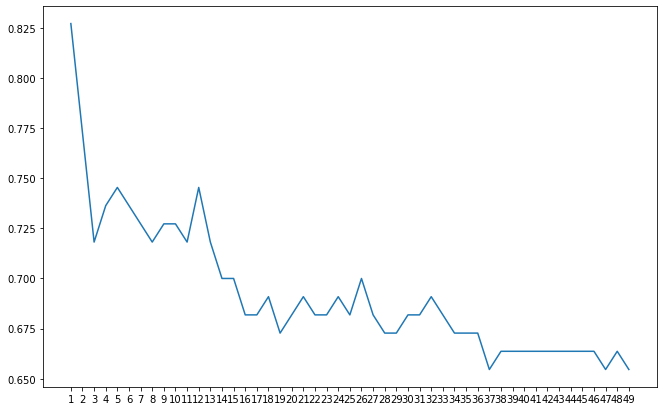

In [17]:
from sklearn.neighbors import KNeighborsClassifier

k_list = range(1, 50)
error = []
for k in k_list: 
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xtrain_pca, ytrain_pca)
    pred_k = knn.predict(Xtest_pca)
    error.append(np.mean(pred_k != ytest_pca))
plt.figure(figsize=(11,7))
plt.plot(k_list, error)
plt.xticks(k_list)
plt.plot()

[]

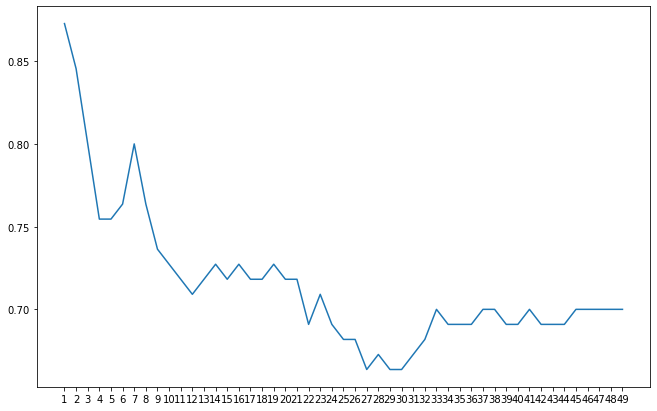

In [18]:
k_list = range(1, 50)
error = []
for k in k_list: 
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xtrain_nocol, ytrain_nocol)
    pred_k_nocol = knn.predict(Xtest_nocol)
    error.append(np.mean(pred_k_nocol != ytest_nocol))
plt.figure(figsize=(11,7))
plt.plot(k_list, error)
plt.xticks(k_list)
plt.plot()

Below we also try using the Manhattan distance metric to see if it improves the accuracy score over the Euclidean method. The automatic Euclidean metric does perform better than the alternate Manhattan distance. 

In [19]:
# Fitting KNN Classififer with K = 19
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(Xtrain_pca, ytrain_pca)
knn_pred0 = knn.predict(Xtest_pca)

knn.score(Xtest_pca, ytest_pca)

0.32727272727272727

In [20]:
# Fitting KNN Classififer with K = 19
knn = KNeighborsClassifier(n_neighbors=19, metric = 'manhattan')
knn.fit(Xtrain_pca, ytrain_pca)
knn_pred0 = knn.predict(Xtest_pca)

knn.score(Xtest_pca, ytest_pca)

0.2909090909090909

In [21]:
# Fitting KNN Classififer with K = 27
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(Xtrain_nocol, ytrain_nocol)
knn_nocol_pred = knn.predict(Xtest_nocol)

knn.score(Xtest_nocol, ytest_nocol)

0.33636363636363636

In [22]:
# Fitting KNN Classififer with K = 27
knn = KNeighborsClassifier(n_neighbors=27, metric = 'manhattan')
knn.fit(Xtrain_nocol, ytrain_nocol)
knn_nocol_pred = knn.predict(Xtest_nocol)

knn.score(Xtest_nocol, ytest_nocol)

0.32727272727272727

## Applying Voting Classifier

Next we employ an ensemble voting classifier which attempts to aggregate the results of Logistic Regression, Random Forest and Support Vector Classifiers to form a more robust model.

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs')
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')
voting_clf.fit(Xtrain_pca, ytrain_pca)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [24]:
# Construct array of accuracy scores for voting classifier.
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(Xtrain_pca, ytrain_pca)
    ypred = clf.predict(Xtest_pca)
    print(clf.__class__.__name__, accuracy_score(ytest, ypred))

LogisticRegression 0.36363636363636365
RandomForestClassifier 0.4909090909090909
SVC 0.35454545454545455
VotingClassifier 0.41818181818181815


From the voting classifier it is clear that Random Forrest performs the best out of all the classifiers.

In [25]:
# Applying SVC classifier with bagging to the full training dataset
LRbag_clf = BaggingClassifier(LogisticRegression(solver='lbfgs'))

bag_clf.fit(X_train, y)
LR_pred = bag_clf.predict(X_test)

test_df3 = pd.DataFrame(data=LR_pred, index=np.array(df1.index))
Id_col = df1[['Id']]
Id_col = Id_col.loc[np.array(df1.index),:]
test_df3 = test_df3.join(Id_col)
test_df3.rename(columns={0: 'top genre'}, inplace=True)
test_df3[['Id', 'top genre']].to_csv('LR_Spotify_Classification.csv',sep = ',', index=None)

### Conclusion

The primary challenge with this investigation was dealing with the high dimensionality of the dataset. This challenge was only exacerbated by the requirement of OHC to convert the categorical features into numerical ones. While various methods and models were tested, we found that both our Random Forest and our Decision Tree (with bagging) classifiers outperformed the other models with a score of 0.5 accuracy. It is worth noting that this is specifically after using pca to reduce dimensionality. If we were to repeat the project within a different environment, we would try and address the high cardinality (high number of unique categories of genre in this dataset) by converting groups of subgenres into more general categories. This should improve the accuracy of the models given that the training set itself is not particularly large compared to the cardinality.